In [1]:
import sys
import yaml
import importlib

from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import emd as np_emd  # Using PyHHT for Empirical Mode Decomposition
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, lfilter
from scipy.signal import hilbert

from box import Box
import pywt



CONFIG_FILENAME = '/home/liranc6/ecg_forecasting/liran_project/mrdiff/src/config_ecg.yml'

assert CONFIG_FILENAME.endswith('.yml')

with open(CONFIG_FILENAME, 'r') as file:
    config = yaml.safe_load(file)

# Add the parent directory to the sys.path
ProjectPath = config['project_path']
sys.path.append(ProjectPath)

# from liran_project.mrdiff.src.parser import parse_args
# from liran_project.utils.util import ecg_signal_difference
# from liran_project.mrdiff.exp_main import Exp_Main
from liran_project.utils.common import *
from liran_project.EMD import sift as my_sift_file
from liran_project.EMD import np_sift as my_np_sift_file

# Add the directory containing the exp module to the sys.path
exp_module_path = os.path.join(ProjectPath, 'mrDiff')
sys.path.append(exp_module_path)

# from mrDiff.models_diffusion.DDPM_CNNNet import *
# from mrDiff.models_diffusion.DDPM_diffusion_worker import *
# from mrDiff.models_diffusion.DDPM import *

hht_path = os.path.join(ProjectPath, 'Hilbert-Huang-transform')
sys.path.append(hht_path)
from torchHHT.hht import emd as torch_emd


In [2]:
%matplotlib inline

In [3]:
# smoothed_factors = [5, 10, 25]
# decompsitions = nn.ModuleList([series_decomp(i) for i in smoothed_factors])
# num_bridges = len(smoothed_factors)

# batch_x_trend_0 = torch.tensor([[1.2052475214004517], [-1.2326127290725708], [0.04800083115696907], [0.19049109518527985], [-0.7563862204551697], [-0.5678967237472534], [0.7916461825370789], [0.07740737497806549], [-0.08014091849327087], [1.0424736738204956], [0.1513906568288803], [1.3039816617965698], [2.051314115524292], [0.36207422614097595], [0.3534039855003357], [0.7216405272483826], [-0.1926405429840088], [-2.0528838634490967], [2.0230884552001953], [0.4104272127151489], [-0.520502507686615], [1.3188446760177612], [-0.9794839024543762], [0.9755717515945435], [-1.461293339729309], [-0.05635882541537285], [-0.10612424463033676], [-0.19961267709732056], [-0.1930353045463562], [0.9049265384674072], [1.3832439184188843], [-0.3818874657154083], [0.4605606198310852], [-1.044301986694336], [0.12567691504955292], [0.6849595904350281], [0.6683170199394226], [-0.29516831040382385], [2.3603708744049072], [-2.9438042640686035], [-0.19197304546833038], [-0.41678449511528015], [0.49438074231147766], [-2.766122817993164], [-0.199421688914299], [-0.1136804074048996], [0.7538848519325256], [-2.3160653114318848], [1.1208761930465698], [-1.764612078666687]])
# batch_x_trend_0.unsqueeze_(0)
# batch_x_trends = []
# for i in range(num_bridges-1):
#             _, batch_x_trend = decompsitions[i](batch_x_trend_0)
#             print(f"{i} = {batch_x_trend.tolist()}")
#             # print("batch_x_trend", np.shape(batch_x_trend))
            
#             plt.plot(batch_x_trend[0,0,:].cpu().numpy())

#             batch_x_trends.append(batch_x_trend.permute(0,2,1))
#             batch_x_trend_0 = batch_x_trend

In [4]:
# import torch

# class TrendExtractor:
#     def __init__(self, num_bridges, smoothing_weights, decompositions):
#         self.num_bridges = num_bridges
#         self.smoothing_weights = smoothing_weights
#         self.decompsitions = decompositions

#     def obtain_multi_trends(self, batch_x):
#         # batch_x: (B, N, L)
#         print(f"Initial batch_x shape: {batch_x.shape}")
        
#         # Permute batch_x to (B, L, N)
#         batch_x = batch_x.permute(0, 2, 1)
#         print(f"After permute batch_x shape: {batch_x.shape}")
        
#         batch_x_trends = []
#         batch_x_trend_0 = batch_x

#         # Sort the smoothing factors based on the learnable weights
#         sorted_indices = torch.argsort(self.smoothing_weights, descending=True)
#         sorted_decompsitions = [self.decompsitions[i] for i in sorted_indices]
        
#         print(f"Smoothing weights: {self.smoothing_weights}")
#         print(f"Sorted smoothing indices: {sorted_indices}")
#         print(f"Number of decompositions: {len(sorted_decompsitions)}")

#         for i in range(self.num_bridges - 1):
#             print(f"\nIteration {i+1}:")
#             # Apply the i-th decomposition function (trend extraction)
#             _, batch_x_trend = sorted_decompsitions[i](batch_x_trend_0)
            
#             print(f"batch_x_trend_0 shape: {batch_x_trend_0.shape}")
#             print(f"Extracted batch_x_trend shape: {batch_x_trend.shape}")
            
#             # Store trend after permuting it back to (B, N, L)
#             batch_x_trends.append(batch_x_trend.permute(0, 2, 1))
#             batch_x_trend_0 = batch_x_trend  # Update for the next iteration
            
#             print(f"batch_x_trend shape after permute: {batch_x_trends[-1].shape}")

#         return batch_x_trends

# # Mock decomposition functions
# def mock_decomposition(x):
#     # Mock function returns two parts (irrelevant for now, we only care about the second part)
#     return x, x * 0.5  # Just returns 50% scaled version as the "trend"

# # Example usage
# B, N, L = 2, 3, 5  # Batch size, num features, sequence length
# batch_x = torch.randn(B, N, L)  # Random input batch

# # Initialize a mock TrendExtractor
# num_bridges = 3
# smoothing_weights = torch.tensor([0.7, 0.5, 0.9])  # Some arbitrary weights
# decompositions = [mock_decomposition, mock_decomposition, mock_decomposition]  # Three mock functions

# extractor = TrendExtractor(num_bridges, smoothing_weights, decompositions)

# # Call the function with the print statements
# batch_x_trends = extractor.obtain_multi_trends(batch_x)

# print("\nFinal trends:")
# for i, trend in enumerate(batch_x_trends):
    # print(f"Trend {i+1} shape: {trend.shape}")
    # print(trend)
    

In [5]:
signal = \
        [-0.2682677751603517, -0.2682677751603517, -0.22699580975106684, -0.17540585298946074, -0.10833890919937281, -0.051589956761606104, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.04127196540928488, -0.04127196540928488, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.04127196540928488, 0.04127196540928488, 0.051589956761606104, 0.051589956761606104, 0.051589956761606104, 0.06706694379008793, 0.06706694379008793, 0.08254393081856976, 0.08254393081856976, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.08254393081856976, 0.08254393081856976, 0.06706694379008793, 0.06706694379008793, 0.051589956761606104, 0.051589956761606104, 0.04127196540928488, 0.04127196540928488, 0.025794978380803052, 0.025794978380803052, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, -0.01547698702848183, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.025794978380803052, 0.06706694379008793, 0.09286192217089098, 0.10833890919937281, 0.06706694379008793, -0.01547698702848183, -0.11865690055169403, -0.24247279677954867, -0.32501672759811845, -0.3611296973312427, -0.3508117059789215, -0.3095397405696366, -0.24247279677954867, -0.17540585298946074, -0.11865690055169403, -0.06706694379008793, -0.051589956761606104, -0.04127196540928488, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.025794978380803052, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.04127196540928488, 0.04127196540928488, 0.051589956761606104, 0.051589956761606104, 0.06706694379008793, 0.08254393081856976, 0.08254393081856976, 0.09286192217089098, 0.09286192217089098, 0.10833890919937281, 0.10833890919937281, 0.11865690055169403, 0.11865690055169403, 0.13413388758017586, 0.13413388758017586, 0.13413388758017586, 0.13413388758017586, 0.13413388758017586, 0.13413388758017586, 0.13413388758017586, 0.11865690055169403, 0.11865690055169403, 0.10833890919937281, 0.09286192217089098, 0.08254393081856976, 0.06706694379008793, 0.06706694379008793, 0.06706694379008793, 0.051589956761606104, 0.04127196540928488, 0.025794978380803052, 0.025794978380803052, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, -0.01547698702848183, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.025794978380803052, 0.06706694379008793, 0.10833890919937281, 0.10833890919937281, 0.06706694379008793, 0.0, -0.11865690055169403, -0.24247279677954867, -0.32501672759811845, -0.37660668435972455, -0.37660668435972455, -0.33533471895043965, -0.2682677751603517, -0.2012008313702638, -0.14961087460865768, -0.09286192217089098, -0.051589956761606104, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.04127196540928488, 0.04127196540928488, 0.051589956761606104, 0.06706694379008793, 0.06706694379008793, 0.08254393081856976, 0.08254393081856976, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.10833890919937281, 0.11865690055169403, 0.11865690055169403, 0.11865690055169403, 0.13413388758017586, 0.13413388758017586, 0.13413388758017586, 0.13413388758017586, 0.13413388758017586, 0.11865690055169403, 0.11865690055169403, 0.10833890919937281, 0.09286192217089098, 0.08254393081856976, 0.06706694379008793, 0.051589956761606104, 0.051589956761606104, 0.04127196540928488, 0.025794978380803052, 0.025794978380803052, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, -0.01547698702848183, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.025794978380803052, 0.0, 0.0, 0.0, 0.0, 0.0, 0.025794978380803052, 0.06706694379008793, 0.10833890919937281, 0.11865690055169403, 0.08254393081856976, 0.0, -0.10833890919937281, -0.21667781839874561, -0.2940627535411548, -0.32501672759811845, -0.3095397405696366, -0.2579497838080305, -0.18572384434178196, -0.13413388758017586, -0.08254393081856976, -0.051589956761606104, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.025794978380803052, 0.025794978380803052, 0.04127196540928488, 0.04127196540928488, 0.04127196540928488, 0.051589956761606104, 0.051589956761606104, 0.051589956761606104, 0.06706694379008793, 0.06706694379008793, 0.08254393081856976, 0.08254393081856976, 0.08254393081856976, 0.08254393081856976, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.08254393081856976, 0.08254393081856976, 0.06706694379008793, 0.051589956761606104, 0.051589956761606104, 0.04127196540928488, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.04127196540928488, 0.04127196540928488, 0.025794978380803052, 0.01547698702848183, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.04127196540928488, 0.09286192217089098, 0.11865690055169403, 0.11865690055169403, 0.06706694379008793, -0.01547698702848183, -0.13413388758017586, -0.24247279677954867, -0.3095397405696366, -0.33533471895043965, -0.32501672759811845, -0.2682677751603517, -0.21667781839874561, -0.14961087460865768, -0.08254393081856976, -0.051589956761606104, -0.025794978380803052, -0.025794978380803052, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.04127196540928488, 0.04127196540928488, 0.04127196540928488, 0.051589956761606104, 0.051589956761606104, 0.06706694379008793, 0.06706694379008793, 0.08254393081856976, 0.08254393081856976, 0.08254393081856976, 0.08254393081856976, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.10833890919937281, 0.10833890919937281, 0.10833890919937281, 0.10833890919937281, 0.10833890919937281, 0.10833890919937281, 0.10833890919937281, 0.09286192217089098, 0.08254393081856976, 0.06706694379008793, 0.051589956761606104, 0.04127196540928488, 0.04127196540928488, 0.025794978380803052, 0.025794978380803052, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.04127196540928488, 0.08254393081856976, 0.13413388758017586, 0.14961087460865768]

In [6]:
original_signal = np.array(signal)

In [7]:
# class ECGDecomposer:
#     def __init__(self, ecg_signal, num_comp, method='pca', wavelet='db4', window_size=5, lowpass_cutoff=None):
#         """
#         Initialize the decomposer class.
        
#         Parameters:
#         - ecg_signal: the ECG time series signal to decompose.
#         - num_comp: the number of components to extract from the decomposition.
#         - method: the method of decomposition ('pca', 'wavelet', 'emd', 'fft', 'moving_avg', 'lowpass').
#         - wavelet: the wavelet type to use for wavelet decomposition (default 'db4').
#         - window_size: the window size for moving average decomposition (default 5).
#         - lowpass_cutoff: the cutoff frequency for low-pass filtering (default None).
#         """
#         self.ecg_signal = ecg_signal
#         self.num_comp = min(num_comp, len(ecg_signal))
#         self.method = method.lower()
#         self.wavelet = wavelet
#         self.window_size = window_size
#         self.lowpass_cutoff = lowpass_cutoff
        
#     def decompose(self):
#         """
#         Decompose the ECG signal based on the selected method.
        
#         Returns:
#         - A list of decomposed components.
#         """
#         if self.method == 'pca':
#             return self._pca_decomposition()
#         elif self.method == 'wavelet':
#             return self._wavelet_decomposition()
#         elif self.method == 'emd':
#             return self._emd_decomposition()
#         elif self.method == 'fft':
#             return self._fft_decomposition()
#         elif self.method == 'moving_avg':
#             return self._moving_average_decomposition()
#         elif self.method == 'lowpass':
#             return self._lowpass_filter_decomposition()
#         else:
#             raise ValueError(f"Method {self.method} not recognized. Use 'pca', 'wavelet', 'emd', 'fft', 'moving_avg', or 'lowpass'.")

#     def _pca_decomposition(self):
#         """ Decompose the ECG signal using PCA (Principal Component Analysis). """
#         ecg_signal_reshaped = self.ecg_signal.reshape(1, -1)
#         pca = PCA(n_components=self.num_comp)
#         components = pca.fit_transform(ecg_signal_reshaped)
#         return components
    
#     def _wavelet_decomposition(self):
#         """ Decompose the ECG signal using Wavelet Transform. """
#         coeffs = pywt.wavedec(self.ecg_signal, wavelet=self.wavelet, level=self.num_comp-1)
#         return coeffs[:self.num_comp]
    
#     def _emd_decomposition(self):
#         """ Decompose the ECG signal using Empirical Mode Decomposition (EMD). """
#         imfs = emd.sift.sift(self.ecg_signal)
#         return imfs[:self.num_comp]
    
#     def _fft_decomposition(self):
#         """ Decompose the ECG signal using Fast Fourier Transform (FFT). """
#         fft_coeffs = np.fft.fft(self.ecg_signal)
#         # Return the first num_comp coefficients and their inverse FFT representations
#         fft_components = [np.fft.ifft(fft_coeffs[:i + 1]).real for i in range(self.num_comp)]
#         return fft_components
    
#     def _moving_average_decomposition(self):
#         """ Compute moving average decomposition. """
#         window_sizes = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 130, 150, 170, 200]  # Example window sizes
#         comps = []
#         comp = self.ecg_signal
#         for w in window_sizes[:self.num_comp]:
#             comp = np.convolve(comp, np.ones(w) / w, mode='same') #np.convolve(self.ecg_signal, np.ones(w) / w, mode='same')
#             comps.append(comp)
#         return comps
    
#     def _lowpass_filter_decomposition(self):
#         """ Apply low-pass filtering to the ECG signal. """
#         # Define Butterworth filter parameters
#         nyquist = 0.5 * len(self.ecg_signal)  # Nyquist frequency
#         cutoff_freqs = np.linspace(0.1, self.lowpass_cutoff, self.num_comp)  # Generate cutoff frequencies
#         comps = []
        
#         for cutoff in cutoff_freqs:
#             # Design Butterworth filter
#             b, a = butter(N=4, Wn=cutoff / nyquist, btype='high')
#             filtered_signal = lfilter(b, a, self.ecg_signal)
#             comps.append(filtered_signal)
        
#         return comps
    
# def plot_components(original_signal, components, method, wavelet=None):
#     """
#     Plot the original ECG signal and its decomposed components.
    
#     Parameters:
#     - original_signal: The original ECG time series signal.
#     - components: The decomposed components of the signal.
#     - method: The decomposition method used.
#     - wavelet: Optional wavelet name if wavelet decomposition is used.
#     """
#     num_components = len(components)
#     fig_height = 2 * (num_components + 1)  # Adjust height based on number of components
#     plt.figure(figsize=(12, fig_height))
    
#     plt.subplot(num_components + 1, 1, 1)
#     plt.plot(original_signal)
#     plt.title('Original ECG Signal')
    
#     for i, component in enumerate(components):
#         plt.subplot(num_components + 1, 1, i + 2)
#         plt.plot(component)
#         plt.title(f'{method.capitalize()} Component {i + 1}' + (f' ({wavelet})' if wavelet else ''))
#         plt.grid()
    
#     plt.tight_layout()
#     plt.show()

# # Example usage
# if __name__ == "__main__":
#     # Sample ECG signal (for illustration, replace with actual ECG signal)
#     original_signal = np.sin(ecg_signal)  # Example synthetic signal
    
#     num_comp = 10
    
#     # # Decomposition using EMD
#     # decomposer_emd = ECGDecomposer(ecg_signal, num_comp=num_comp, method='emd')
#     # components_emd = decomposer_emd.decompose()
#     # plot_components(ecg_signal, components_emd, method='emd')
    
#     # # Decomposition using FFT 
#     # decomposer_fft = ECGDecomposer(ecg_signal, num_comp=num_comp, method='fft')
#     # components_fft = decomposer_fft.decompose()
#     # plot_components(ecg_signal, components_fft, method='fft')
    
#     # Decomposition using Moving Average
#     # decomposer_moving_avg = ECGDecomposer(original_signal, num_comp=num_comp, method='moving_avg', window_size=[5, 10, 20])
#     # components_moving_avg = decomposer_moving_avg.decompose()
#     # plot_components(original_signal, components_moving_avg, method='moving_avg')
    
#     # Decomposition using Low-pass filtering
#     # decomposer_lowpass = ECGDecomposer(ecg_signal, num_comp=num_comp, method='lowpass', lowpass_cutoff=0.1)
#     # components_lowpass = decomposer_lowpass.decompose()
#     # plot_components(ecg_signal, components_lowpass, method='lowpass')
    
#     # # Define a list of wavelets to test
#     # wavelets = ['db4', 'haar', 'coif1', 'coif2']
    
#     # # Loop through each wavelet and decompose the signal, then plot the components
#     # for wavelet in wavelets:
#     #     decomposer_wavelet = ECGDecomposer(ecg_signal, num_comp=num_comp, method='wavelet', wavelet=wavelet)
#     #     components_wavelet = decomposer_wavelet.decompose()
#     #     plot_components(ecg_signal, components_wavelet, method='wavelet', wavelet=wavelet)


In [8]:
# print(pywt.wavelist(kind='continuous'))

In [9]:

def plot_signals(x, reconstructed_x):
    """
    Plots the original signal and the reconstructed signal on the same graph.
    If one of the signals is None, it only plots the other signal.

    Parameters:
    x (array-like or None): The original signal.
    reconstructed_x (array-like or None): The reconstructed signal.
    """
    plt.figure(figsize=(10, 6))

    # Plot the original signal if it is not None
    if x is not None:
        plt.plot(x, color='blue', label='Original Signal')

    # Plot the reconstructed signal if it is not None
    if reconstructed_x is not None:
        plt.plot(reconstructed_x, color='red', linestyle='--', label='Reconstructed Signal')

    # Add title and labels
    plt.title('Original vs Reconstructed Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Add a legend if at least one signal is plotted
    if x is not None or reconstructed_x is not None:
        plt.legend()

    # Show the plot
    plt.show()


In [10]:


class SignalDecomposer:
    def __init__(self, original_signal, num_comp, method='emd'):
        """
        Initialize the decomposer class.
        
        Parameters:
        - original_signal: the signal to decompose.
        - num_comp: the number of components to extract from the decomposition.
        - method: the method of decomposition ('pca', 'wavelet', 'emd', 'fft', 'moving_avg', 'lowpass').
        """
        self.attributes = Box(default_box=True, default_box_none_transform=True)
        self.attributes.original_signal = original_signal
        self.attributes.num_comp = num_comp
        self.attributes.method = method.lower()
        self.attributes.fs = 250  # Default sampling frequency
        
    def decompose(self, method=None, extra_params: dict = {}):
        """
        Decompose the signal based on the selected method.
        
        Returns:
        - A list of decomposed components.
        """
        if method is not None:
            self.attributes.method = method.lower()
            
        self.attributes.update(extra_params)    
            
        print(f"Decomposing signal using {self.attributes.method} method to extract {self.attributes.num_comp} components")
        if self.attributes.method == 'pca':
            return self._pca_decomposition()
        elif self.attributes.method == 'wavelet':
            return self._wavelet_decomposition()
        elif self.attributes.method == 'emd':
            return self._emd_decomposition()
        elif self.attributes.method == 'hht':
            return self._hht_decomposition()
        elif self.attributes.method == 'fft':
            return self._fft_decomposition()
        elif self.attributes.method == 'moving_avg':
            return self._moving_average_decomposition()
        elif self.attributes.method == 'lowpass':
            return self._lowpass_filter_decomposition()
        else:
            raise ValueError(f"Method {self.attributes.method} not recognized. Use 'pca', 'wavelet', 'emd', 'fft', 'moving_avg', or 'lowpass'.")

    def reconstruct(self, components, method=None, extra_params: dict = {}):
        """
        Reconstruct the signal from the decomposed components.
        
        Parameters:
        - components: the list of decomposed components.
        
        Returns:
        - The reconstructed signal.
        """
        if method is not None:
            self.attributes.method = method.lower()
            
        self.attributes.update(extra_params)
        
        print(f"reconstruction signal using {self.attributes.method} method from {len(components)} components")
        if self.attributes.method == 'pca':
            return self._pca_reconstruct(components)
        elif self.attributes.method == 'wavelet':
            return self._wavelet_reconstruct(components)
        elif self.attributes.method == 'emd':
            return self._emd_reconstruct(components)
        elif self.attributes.method == 'hht':
            return self._hht_reconstruct(components)
        elif self.attributes.method == 'fft':
            return self._fft_reconstruct(components)
        elif self.attributes.method == 'moving_avg':
            return self._moving_average_reconstruct(components)
        elif self.attributes.method == 'lowpass':
            return self._lowpass_filter_reconstruct(components)
        else:
            raise ValueError(f"Method {self.attributes.method} not recognized. Use 'pca', 'wavelet', 'emd', 'fft', 'moving_avg', or 'lowpass'.")
        
    def _pca_decomposition(self):
        """ Decompose the signal using PCA (Principal Component Analysis). """
        raise NotImplementedError("Has bugs. PCA decomposition is not yet implemented.")
        
        signal_reshaped = self.attributes.original_signal.reshape(-1, 1)  # Reshape to 2D for PCA

        # Perform PCA decomposition
        pca = PCA(n_components=self.attributes.num_comp)
        components = pca.fit_transform(signal_reshaped)

        # Reconstruct the signal using the specified number of components
        reconstructed_signal = pca.inverse_transform(components)
        
        assert np.allclose(self.attributes.original_signal, reconstructed_signal), "Reconstruction failed"
        
        return components
    
    def _pca_reconstruct(self, components):
        raise NotImplementedError("Has bugs. PCA decomposition is not yet implemented.")
    
    def _wavelet_decomposition(self):
        """ Decompose the signal using Wavelet Transform. """
        coeffs = pywt.wavedec(self.attributes.original_signal, wavelet=self.attributes.wavelet, level=self.attributes.num_comp-1)
        
        reconstructed_signal = self._wavelet_reconstruct(coeffs)
        assert np.allclose(self.attributes.original_signal, reconstructed_signal, atol=1.e-10), "Reconstruction failed"
        return coeffs
    
    def _wavelet_reconstruct(self, components):
        reconstructed_signal = pywt.waverec(components, wavelet=self.attributes.wavelet)
        return reconstructed_signal
    
    def _emd_decomposition(self):
        """ Decompose the signal using Empirical Mode Decomposition (EMD). """
        """Note:
        I did: 
        pip uninstall emd
        pip install -e git+https://gitlab.com/emd-dev/emd.git#egg=emd
        export PYTHONPATH=/home/liranc6/ecg_forecasting/src/emd:$PYTHONPATH
        """
        imfs = np_emd.sift.sift(self.attributes.original_signal, max_imfs=self.attributes.num_comp-1)
        imfs = imfs.T
        assert imfs.shape[0] == self.attributes.num_comp, f"Insufficient IMFs for reconstruction: {imfs.shape[0]}, {self.attributes.num_comp}"
        # Sum the first num_comp IMFs along axis 1 to reconstruct the signal
        reconstructed_signal = self._emd_reconstruct(imfs)
        assert np.allclose(self.attributes.original_signal, reconstructed_signal), "Reconstruction failed"
        
        return imfs
    
    def _emd_reconstruct(self, components):
        """ Reconstruct the signal using Empirical Mode Decomposition (EMD). """
        reconstructed_signal = np.sum(components, axis=0)
        return reconstructed_signal
    
    def _hht_decomposition(self):
        """ Decompose the signal using Hilbert-Huang Transform (HHT). """
        # Step 1: Decompose the signal using EMD (Empirical Mode Decomposition)
        imfs = np_emd.sift.sift(self.attributes.original_signal, max_imfs=self.attributes.num_comp-1)
        imfs = imfs.T
        
        # Step 2: Perform Hilbert Transform on the imfs to obtain instantaneous frequency and amplitude
        analytic_signal = hilbert(imfs)
        amplitude_envelope = np.abs(analytic_signal).T
        instantaneous_phase = np.unwrap(np.angle(analytic_signal)).T
        instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0 * np.pi)).T
        
        def hht_plt():
            # Plotting
            fig, axs = plt.subplots(3, 1, figsize=(12, 8))
            
            print(f"{imfs.shape=}"\
                    f"{amplitude_envelope.shape=}\n" \
                    f"{instantaneous_phase.shape=}\n" \
                    f"{instantaneous_frequency.shape=}\n"
                )

            # Plot amplitude envelope
            axs[0].plot(amplitude_envelope)
            axs[0].set_title('Amplitude Envelope')
            axs[0].set_xlabel('Sample')
            axs[0].set_ylabel('Amplitude')

            # Plot instantaneous phase
            axs[1].plot(instantaneous_phase)
            axs[1].set_title('Instantaneous Phase')
            axs[1].set_xlabel('Sample')
            axs[1].set_ylabel('Phase (radians)')

            # Plot instantaneous frequency
            axs[2].plot(instantaneous_frequency)
            axs[2].set_title('Instantaneous Frequency')
            axs[2].set_xlabel('Sample')
            axs[2].set_ylabel('Frequency (Hz)')
            
            plot_signals(self.attributes.original_signal, None)
            
        # hht_plt()

        # Reconstruct the signal
        reconstructed_signal = self._hht_reconstruct(imfs)

        # Check if the reconstruction is correct
        assert np.allclose(reconstructed_signal, self.attributes.original_signal), "Reconstruction failed"

        return imfs
    
    def _hht_reconstruct(self, components):
        """ Reconstruct the signal using Hilbert-Huang Transform (HHT). """
        reconstructed_signal = np.sum(components, axis=0)
        return reconstructed_signal       
    
    def _fft_decomposition(self):
        """ Decompose the signal using Fast Fourier Transform (FFT). """
        # Perform FFT on the original signal
        fft_coeffs = np.fft.fft(self.attributes.original_signal)
        
        fft_coeffs = fft_coeffs[:250]
        
        print(f"{len(fft_coeffs)} FFT coefficients")
        
        # Get the number of coefficients
        num_coeffs = len(fft_coeffs)

        # Create a list to hold the selected components
        fft_components = []
        
        step = num_coeffs // self.attributes.num_comp
        
        # Divide the coefficients into self.attributes.num_comp parts
        for i in range(0, num_coeffs, step):
            # Zero out all coefficients except the current part
            temp_coeffs = np.zeros_like(fft_coeffs, dtype=complex)
            temp_coeffs[:i+step] = fft_coeffs[:i+step]
            
            # Compute the inverse FFT to get the time domain representation of the selected components
            partial_comp = np.fft.ifft(temp_coeffs).real
            fft_components.append(partial_comp)
        
        # for i in range(self.attributes.num_comp, step=step):
        #     # Create a copy of the FFT coefficients and set the rest to zero for reconstruction
        #     modified_coeffs = np.zeros(num_coeffs, dtype=complex)
        #     modified_coeffs[:i + 1] = fft_coeffs[:i + 1]  # Retain the first (i + 1) coefficients

        #     # Compute the inverse FFT to get the time domain representation of the selected components
        #     fft_components.append(np.fft.ifft(modified_coeffs).real)

        # Reconstruct the original signal using the selected components
        
        
                  
        return fft_components
    
    def _fft_reconstruct(self, components):
        """ Reconstruct the signal using Fast Fourier Transform (FFT). """
        raise NotImplementedError("FFT reconstruction is hard to implement.")
        
    def _moving_average_decomposition(self):
        """ Compute moving average decomposition. """
        # window_sizes = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 130, 150, 170, 200]  # Example window sizes
        comps = []
        comp = self.attributes.original_signal
        for w in self.attributes.window_sizes:
            comp = np.convolve(comp, np.ones(w) / w, mode='same')
            comps.append(comp)
        return comps
    
    def _moving_average_reconstruct(self, components):
        """ Reconstruct the signal using moving average decomposition. """
        raise NotImplementedError("Moving average reconstruction is hard to implement.")
    
    def _lowpass_filter_decomposition(self):
        """ Apply low-pass filtering to the signal. """
        # Define Butterworth filter parameters
        nyquist = 0.5 * 250  # Nyquist frequency
        cutoff_freqs = np.linspace(0.1 * nyquist, self.attributes.lowpass_cutoff, self.attributes.num_comp)  # Generate cutoff frequencies
        comps = []
        
        for cutoff in cutoff_freqs:
            # Design Butterworth filter
            b, a = butter(N=self.attributes.num_comp, Wn=cutoff / nyquist, btype='low')
            filtered_signal = lfilter(b, a, self.attributes.original_signal)
            comps.append(filtered_signal)
        
        return np.array(comps)
    
        nyquist = 0.5 * len(self.attributes.original_signal) # Nyquist frequency
        cutoff_freqs = np.linspace(0.1, self.attributes.lowpass_cutoff, self.attributes.num_comp)  # Generate cutoff frequencies
        comps = []
        
        for cutoff in cutoff_freqs:
            # Design Butterworth filter
            b, a = butter(N=self.attributes.num_comp, Wn=cutoff / nyquist, btype='high')
            filtered_signal = filtfilt(b, a, self.attributes.original_signal)
            comps.append(filtered_signal)
            
        reconstructed_signal = self._lowpass_filter_reconstruct(comps)
        
        return np.array(comps).T
    
    def _lowpass_filter_reconstruct(self, components):
        """ Reconstruct the signal using low-pass filtering. """
        raise NotImplementedError("Low-pass filter not suitable for reconstraction.")
        



# Example usage
num_comp = 6   
signal_decomposer = SignalDecomposer(original_signal, num_comp=num_comp)

#emd
emd_components = signal_decomposer.decompose(method='emd')

#wavelet
wavelets = ['db4', 'haar', 'coif1', 'coif2']
components_wavelet = {}
for wavelet in wavelets:
    components_wavelet[wavelet] = signal_decomposer.decompose(method='wavelet', extra_params={'wavelet': wavelet})
    # plot_components(ecg_signal, components_wavelet, method='wavelet', wavelet=wavelet)
    
#fft
decomposer_fft = signal_decomposer.decompose(method='fft', extra_params={'num_comp': num_comp})

# lowpass
decomposer_lowpass = signal_decomposer.decompose(method='lowpass', extra_params={'lowpass_cutoff': 0.1})

#hht
decomposer_hht = signal_decomposer.decompose(method='hht')

window_sizes = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 130, 150, 170, 200]  # Example window sizes
#moving_avg
decomposer_moving_avg = signal_decomposer.decompose(method='moving_avg', extra_params={'window_sizes': window_sizes})

Decomposing signal using emd method to extract 6 components
Decomposing signal using wavelet method to extract 6 components
Decomposing signal using wavelet method to extract 6 components
Decomposing signal using wavelet method to extract 6 components
Decomposing signal using wavelet method to extract 6 components
Decomposing signal using fft method to extract 6 components
250 FFT coefficients
Decomposing signal using lowpass method to extract 6 components
Decomposing signal using hht method to extract 6 components
Decomposing signal using moving_avg method to extract 6 components


In [11]:
# import emd
# import os

# #get emd.sift file path
# print(f"{os.path.dirname(emd.sift.__file__)=}")

In [12]:
import numpy as np
from emd.sift import sift  # Assuming sift.py is in the same directory or properly installed

# Create a sample time-series data array
time = np.linspace(0, 1, 10)
data = np.sin(2 * np.pi * 5 * time) + 0.5 * np.sin(2 * np.pi * 10 * time)

# Call the sift function with the sample data
imfs = sift(data, max_imfs=4)

# Print the resulting Intrinsic Mode Functions (IMFs)
print("Intrinsic Mode Functions (IMFs):")
print(imfs)

 Inputs samples (10) is small for specified max_imfs (4) very likely that 2 or fewer imfs are returned
Intrinsic Mode Functions (IMFs):
[[ 0.08988516 -0.08988516]
 [-0.28177998  0.26115364]
 [ 0.61025296  0.52493853]
 [-0.88703935  0.45402665]
 [ 1.00770386  0.14811396]
 [-0.97049413 -0.1853237 ]
 [ 0.81717263 -0.38415993]
 [-0.64446812 -0.49072337]
 [ 0.57128345 -0.55065711]
 [ 0.49209354 -0.49209354]]


In [13]:
def plot_and_process_reconstructed_signals(original_signal, components, signal_decomposer:SignalDecomposer=None, **kwargs):
    """
    Processes and plots the reconstructed signals from the given components.
    Parameters:
    original_signal (array-like): The original signal to be processed.
    components (array-like): The components used for signal reconstruction.
    signal_decomposer (SignalDecomposer, optional): An instance of SignalDecomposer used for signal decomposition and reconstruction. Default is None.
    **kwargs: Additional parameters to be passed to the reconstruct method of SignalDecomposer.
    Returns:
    None
    This function performs the following:
    - If a signal_decomposer is provided:
        - Uses the signal_decomposer to reconstruct the signal from its components.
        - Plots the reconstructed signals at each step of the reconstruction process.
    - If no signal_decomposer is provided:
        - Reconstructs the signal by subtracting the sum of components from the original signal.
        - Plots the reconstructed signals at each step of the reconstruction process.
    """
    if signal_decomposer is not None:
        original_signal = signal_decomposer.attributes.original_signal
        for n in range(signal_decomposer.attributes.num_comp-1, 0, -1):
            part_comps = components[n:]
            print(f"{n} -> {signal_decomposer.attributes.num_comp}")
            siganl_reconstructed = signal_decomposer.reconstruct(part_comps, extra_params=kwargs)
            plot_signals(None, siganl_reconstructed)
            
        plot_signals(original_signal, siganl_reconstructed)
        siganl_reconstructed = signal_decomposer.reconstruct(components, extra_params=kwargs)
        plot_signals(original_signal, siganl_reconstructed)
        
    else:
        len_imfs = original_signal.shape[1]
        for n in range(len_imfs-1, 0, -1):
            x_minus_imf = original_signal - np.sum(components[:, :n], axis=1)
            plot_signals(None, x_minus_imf)
        
        plot_signals(original_signal, x_minus_imf)
        plot_signals(original_signal, np.sum(components, axis=1))


In [14]:
print(f"wavelet is not meant to be reconstructed with only some of its components")
for wavelet_type, components in components_wavelet.items():
    continue
    plot_and_process_reconstructed_signals(original_signal, components, signal_decomposer, method='wavelet', wavelet=wavelet_type)

wavelet is not meant to be reconstructed with only some of its components


5 -> 6
reconstruction signal using emd method from 1 components


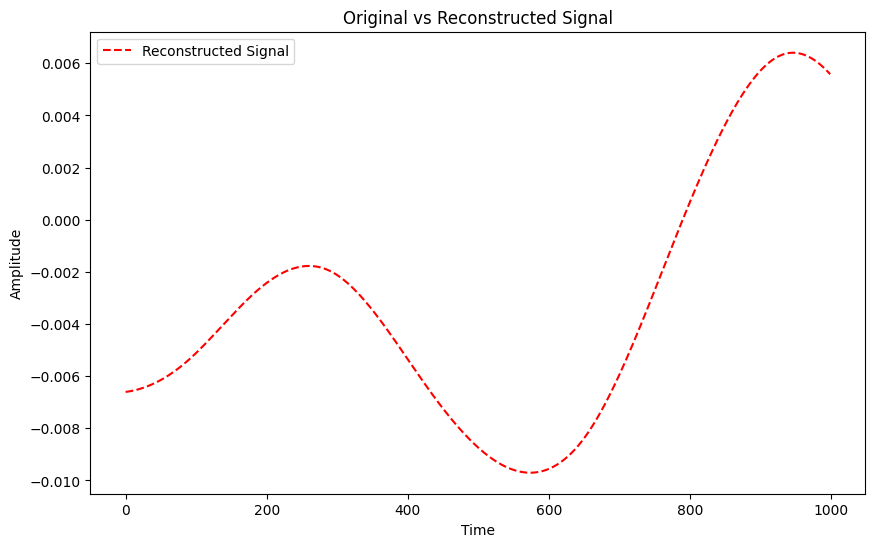

4 -> 6
reconstruction signal using emd method from 2 components


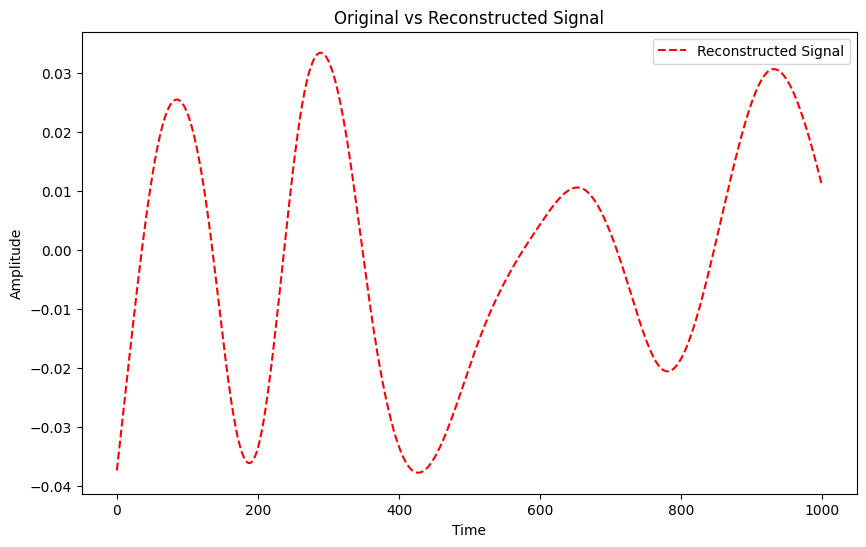

3 -> 6
reconstruction signal using emd method from 3 components


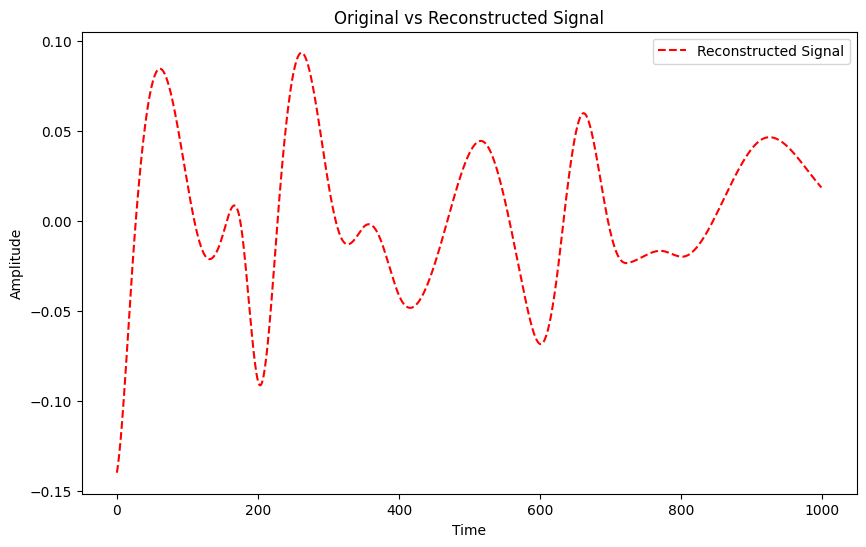

2 -> 6
reconstruction signal using emd method from 4 components


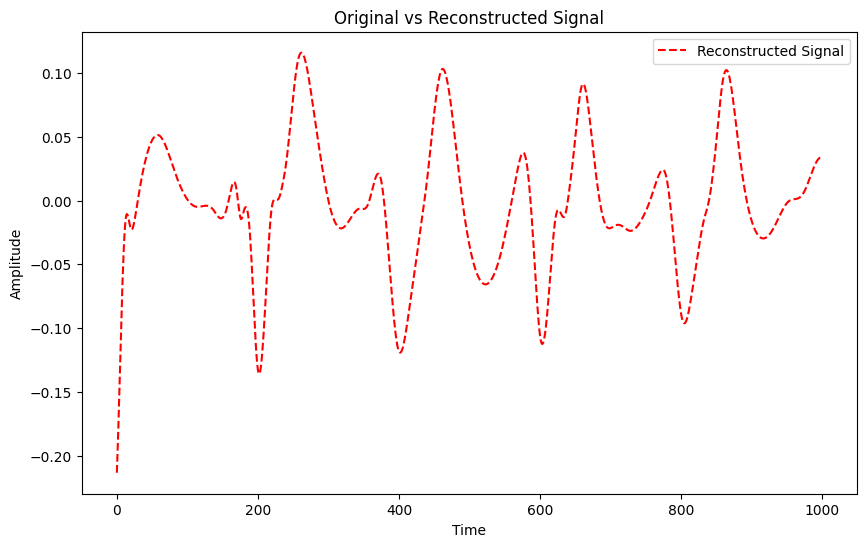

1 -> 6
reconstruction signal using emd method from 5 components


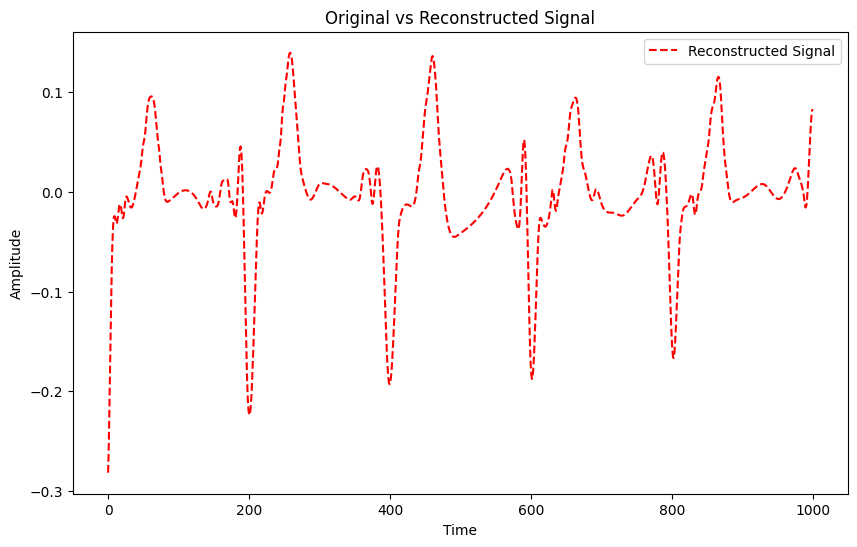

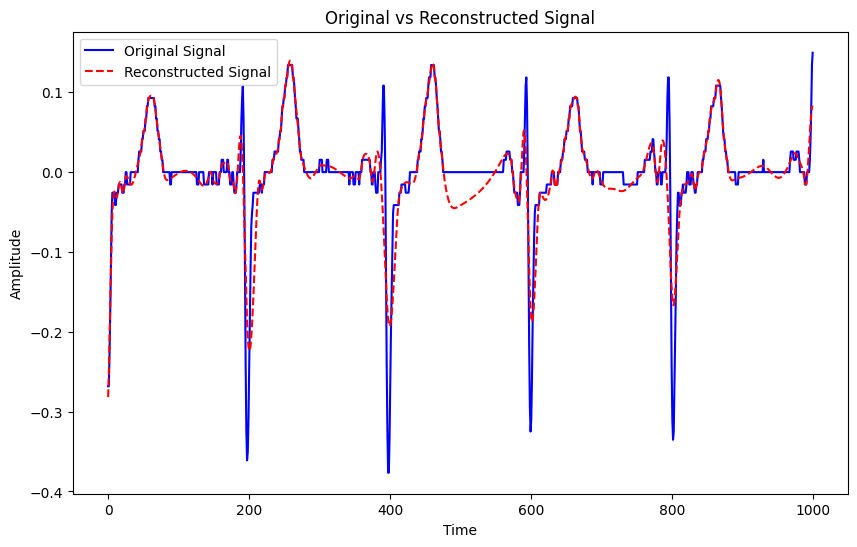

reconstruction signal using emd method from 6 components


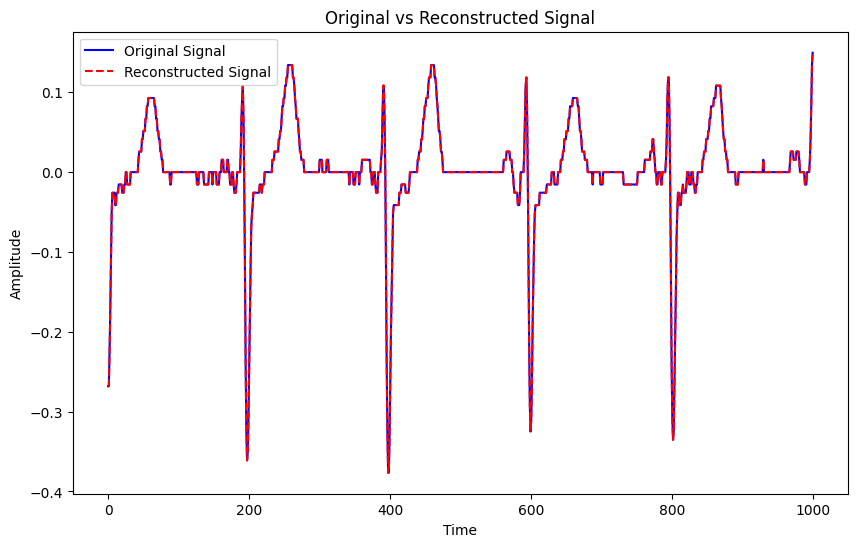

In [15]:
plot_and_process_reconstructed_signals(original_signal, emd_components, signal_decomposer, method='emd')

In [16]:
# for i, win in enumerate(window_sizes):
#     print(f"\n\n" \
#           f"window_size: {win}")
#     plot_signals(original_signal, decomposer_moving_avg[i])

In [17]:
tensor_original_signal = torch.tensor(original_signal, dtype=torch.float64).unsqueeze(0).unsqueeze(-1)
tensor_original_signal.shape

torch.Size([1, 1000, 1])

5 -> 6
reconstruction signal using emd method from 1 components


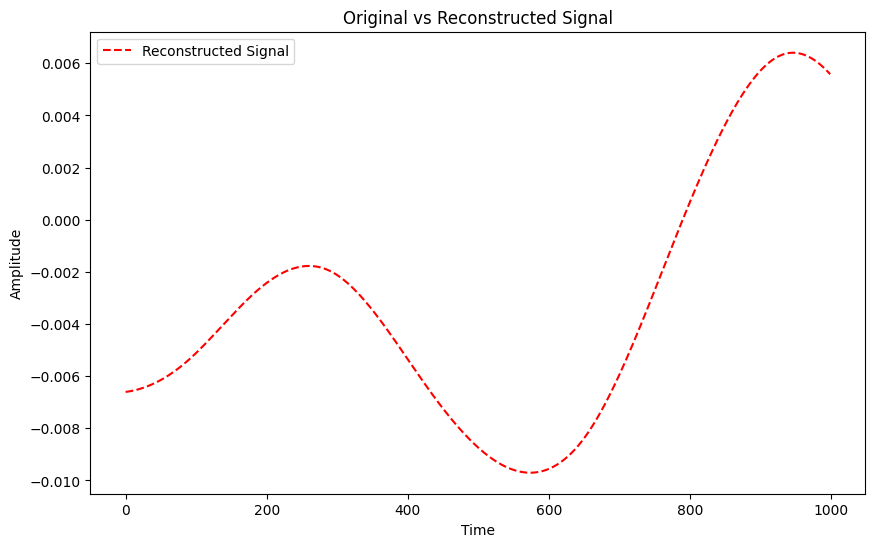

4 -> 6
reconstruction signal using emd method from 2 components


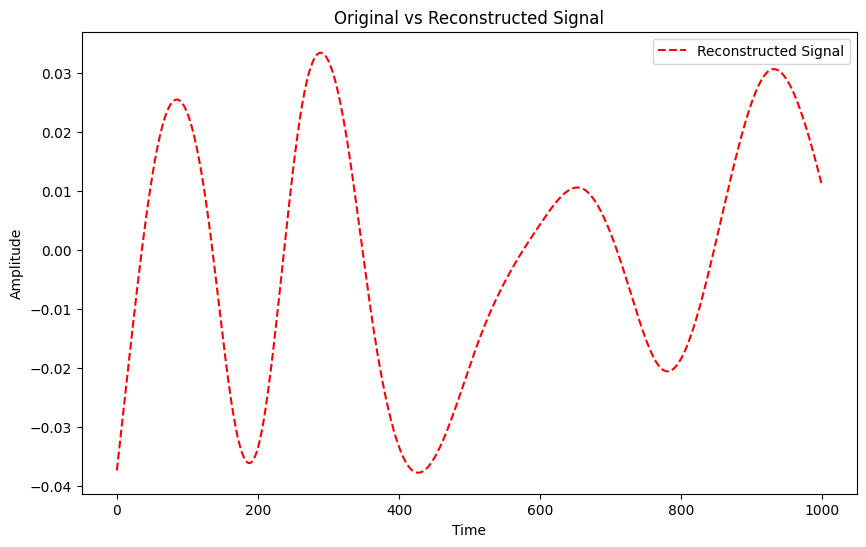

3 -> 6
reconstruction signal using emd method from 3 components


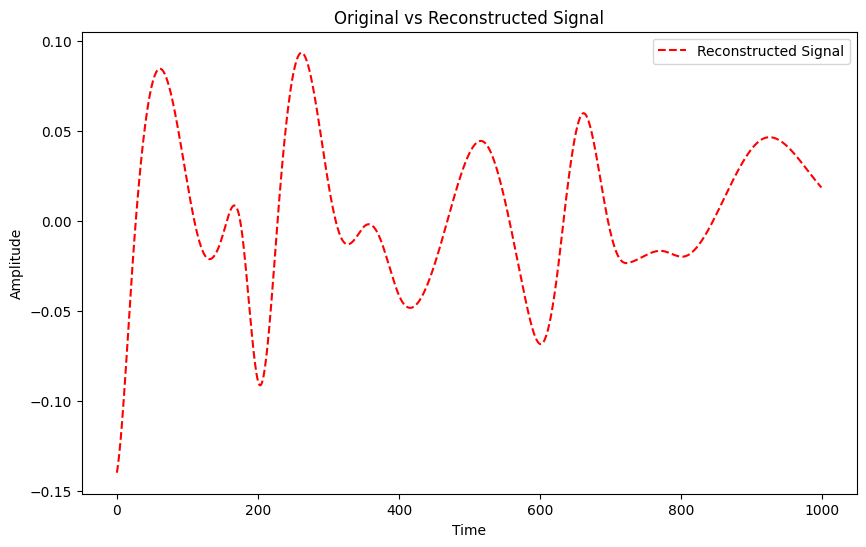

2 -> 6
reconstruction signal using emd method from 4 components


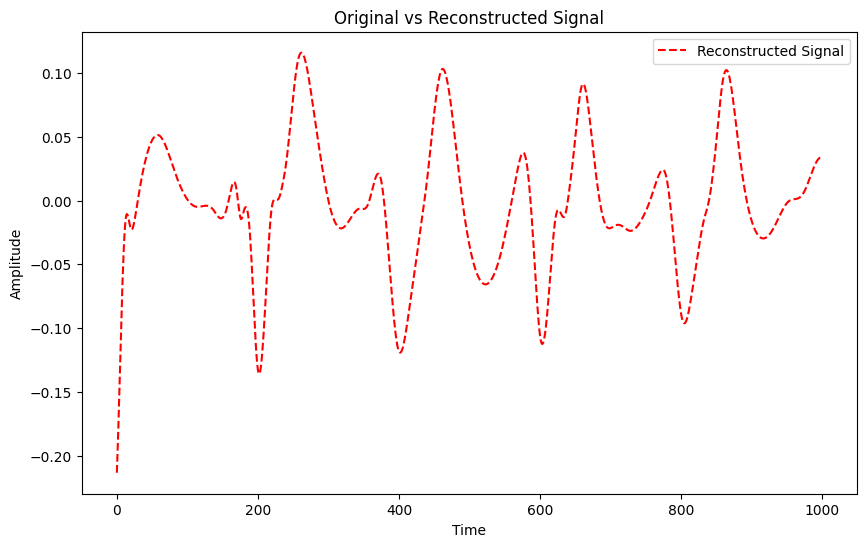

1 -> 6
reconstruction signal using emd method from 5 components


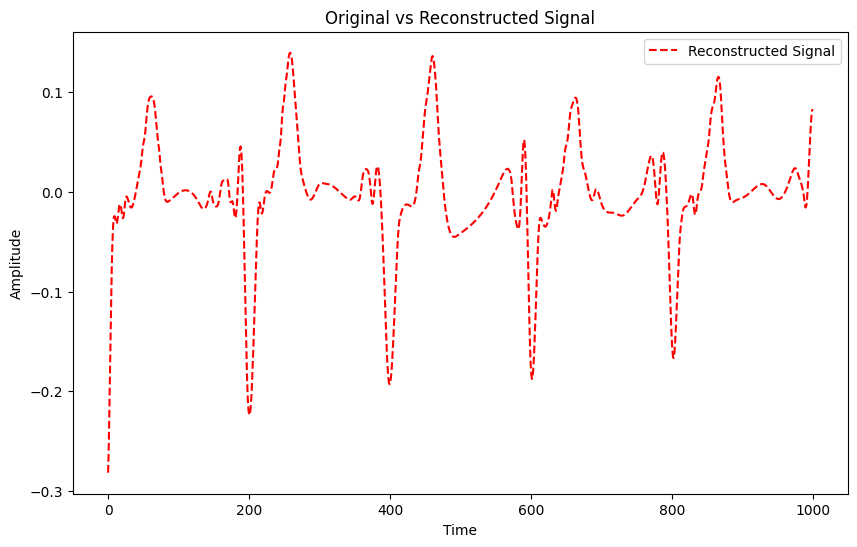

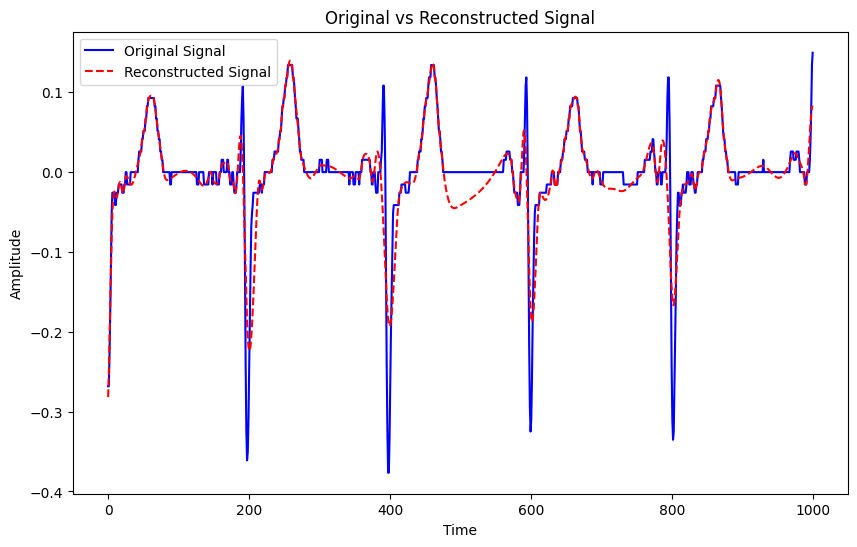

reconstruction signal using emd method from 6 components


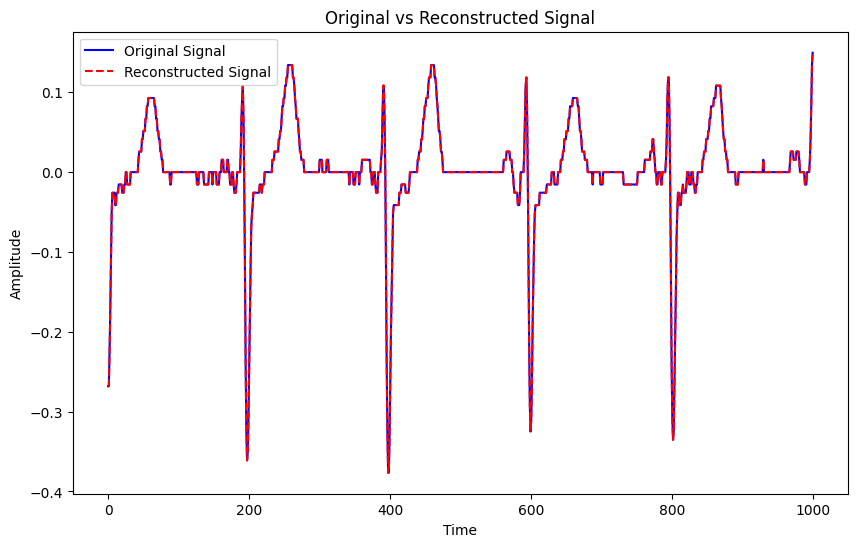

In [23]:
importlib.reload(np_emd.sift)
emd_components = np_emd.sift.sift(original_signal, max_imfs=5)
plot_and_process_reconstructed_signals(original_signal, emd_components.T, signal_decomposer, method='emd')

5 -> 6
reconstruction signal using emd method from 1 components


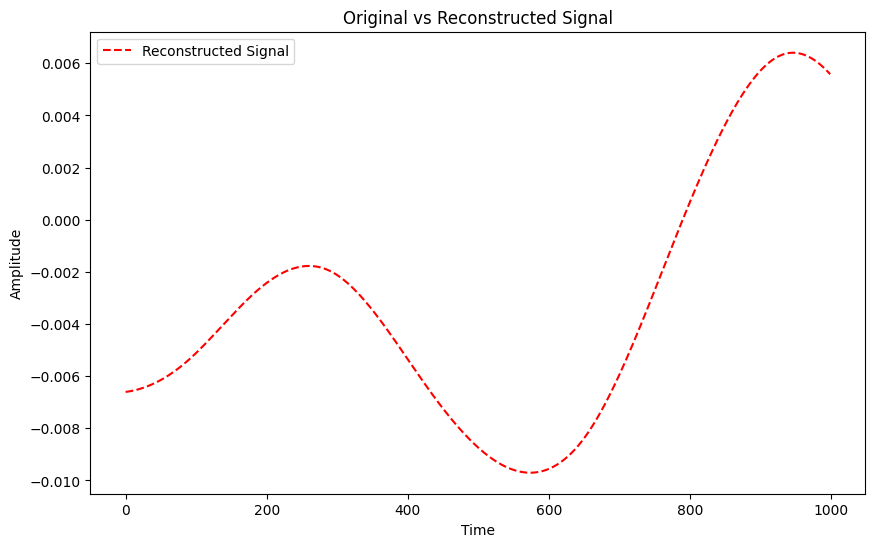

4 -> 6
reconstruction signal using emd method from 2 components


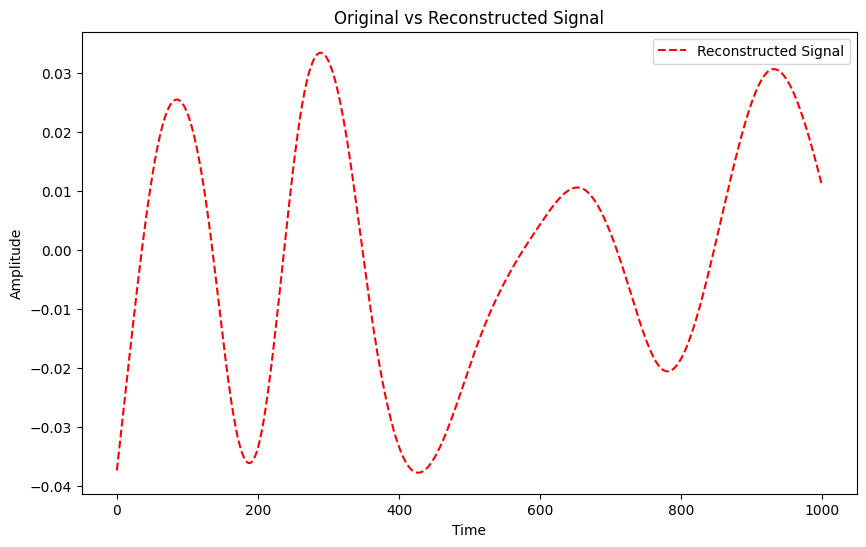

3 -> 6
reconstruction signal using emd method from 3 components


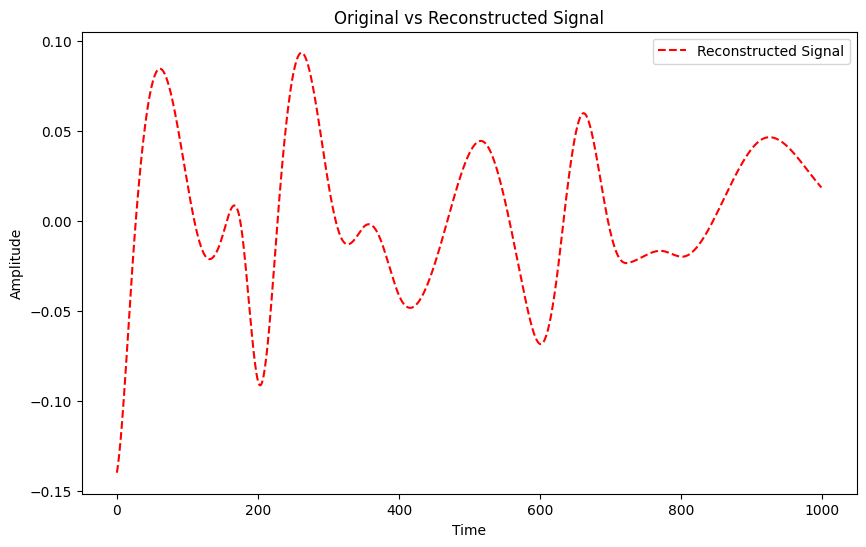

2 -> 6
reconstruction signal using emd method from 4 components


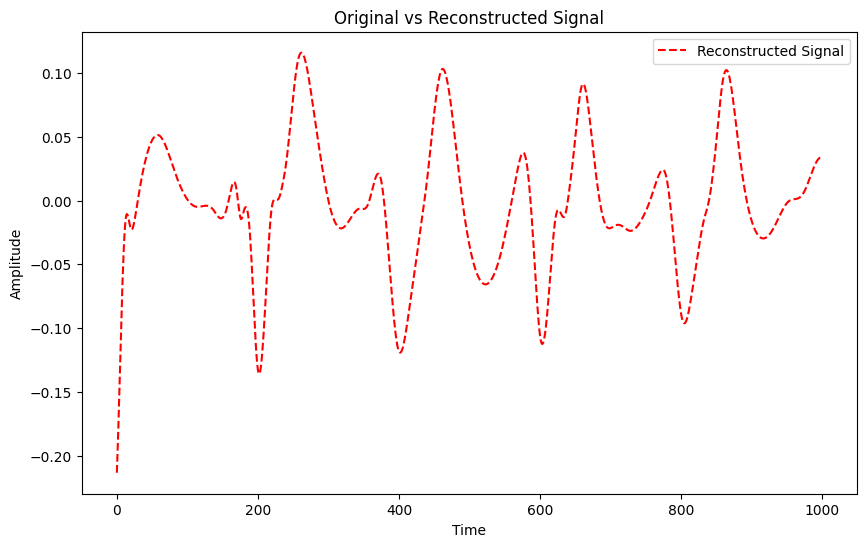

1 -> 6
reconstruction signal using emd method from 5 components


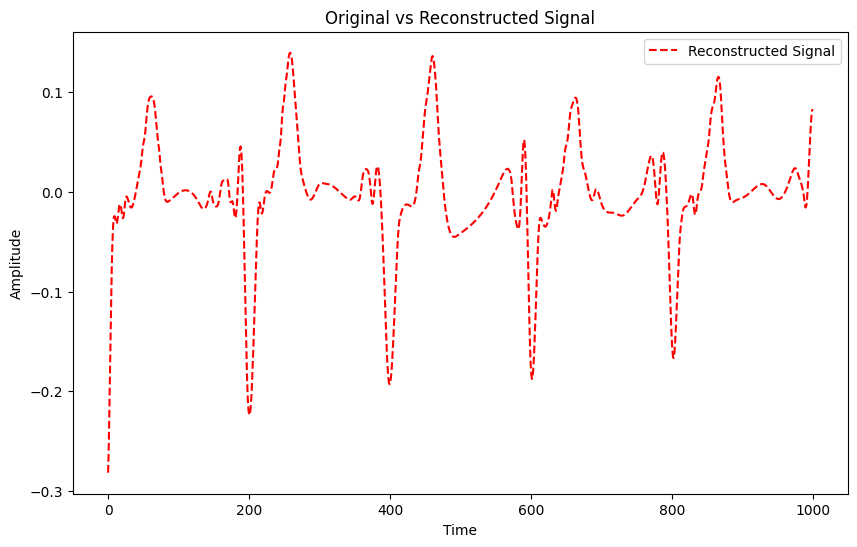

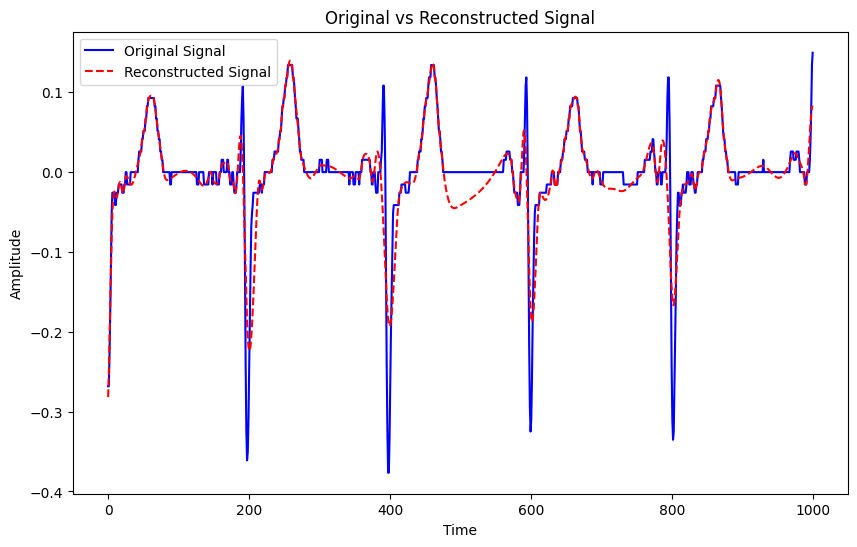

reconstruction signal using emd method from 6 components


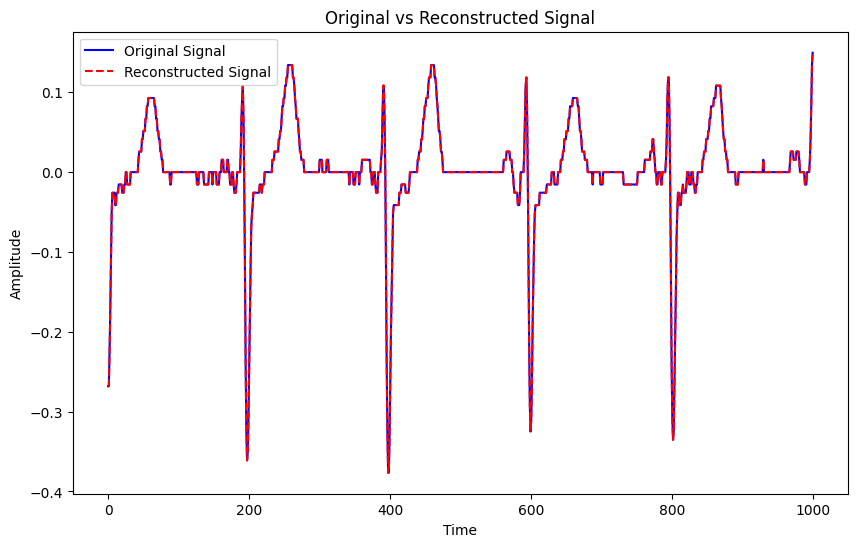

In [34]:
importlib.reload(my_np_sift_file)
emd_components = my_np_sift_file.sift(original_signal, max_imfs=5)
plot_and_process_reconstructed_signals(original_signal, emd_components.T, signal_decomposer, method='emd')